In [1]:
# library
import pandas as pd
import os 
import feather
import numpy as np
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, pearsonr

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

def bool2int(bool):
    boolint = np.full(fill_value=1,shape=len(bool))
    boolint[~bool] =0
    return boolint

def get_RMSE_NLL_NOIS_AWPI_ECPI(y_true,y_pred,y_l,y_u,alpha=0.05):
    awpi = np.mean(y_u - y_l)
    nois = awpi+ (2/alpha)*np.mean(np.multiply((y_l- y_true), bool2int(y_l > y_true)) + 
                          np.multiply((y_true - y_u), bool2int(y_true > y_u))  )
    ecpi = np.sum((y_l <= y_true) & (y_true <= y_u) )/len(y_true)
    
    sd = (y_pred - y_l)/norm.ppf(1- alpha/2)
    py = norm.pdf(y_true,loc = y_pred, scale=sd)
    nll = - np.log(py).mean()
    return  np.sqrt(mean_squared_error(y_true,y_pred)), nll, nois, awpi, ecpi

In [3]:
# read in 
WU = feather.read_dataframe('WU.feather')

# Simulation configuration

In [4]:
# play with these numbers
coefs = np.array([[[0.9,0.1],[0.1,0.5]]])
sigma_u = np.array([[1,0],[0,1]])
coefs_exog = np.array([20.123,20])
vnames = ["TotalWaterUse","ET_turf_month_mean"]

In [5]:
col_names = ['Index', 'TotalWaterUse', 'year', 'month', 'monthIndex',
       'E_Label_ParcelID', 'X_Coord_of_Centroid', 'Y_Coord_ofCentroid',
       'ParcelID', 'AW_percent_month_mean', 'GIR1_month_mean',
       'RAW2_month_mean', 'P_month_mean', 'ET_turf_month_mean', 'XF_AREA',
       'GreenSpace_Est', 'BldVal', 'LndVal', 'Days', 'Shape_Area',
       'E_yearEffmin', 'E_yearActmin', 'E_HeatGrsAreaRatio_Parcel',
       'E_HeatGrsAreaDiff_Parcel', 'E_Parcel_FPE_ALL_Ratio', 'E_freq_pixel',
       'E_Parcel_FPE_XF', 'Set']

# sim

In [6]:
np.random.seed(2)
parcels = WU.E_Label_ParcelID.unique()
# subsample
subsample_size = 100
parcels = np.random.choice(parcels,subsample_size, replace=False)


n_parcels = len(parcels)
# we define eacch parcel's parameters
c1 = np.random.uniform(10,20, n_parcels)
c2 = np.random.uniform(1,20, n_parcels)
a11 = np.random.uniform(0.9,0.95, n_parcels)
a12 = np.random.uniform(0.01,0.1, n_parcels) # must be small!
a21 = np.random.uniform(0.01, 0.05, n_parcels) # must be small!
a22 = np.random.uniform(0.7,0.8, n_parcels)
sig12 = np.random.uniform(0,0, n_parcels)
sig2_1 = np.random.uniform(100,200, n_parcels)
sig2_2 = np.random.uniform(50,60, n_parcels)


In [8]:
np.random.seed(1)
p = 1
alpha = 0.05
steps = 1
var1_sig = []
var12_sig = []
for i, prcl in enumerate(parcels):
    # sim data
    nsteps = WU[WU['E_Label_ParcelID'] == prcl].shape[0]
    coefs = np.array([[[a11[i],a12[i]],[a21[i],a22[i]]]]) # A
    sigma_u = np.array([[sig2_1[i],sig12[i]],[sig12[i],sig2_2[i]]]) # u
    coefs_exog = np.array([c1[i],c2[i]]) # v
    vnames = ["TotalWaterUse","ET_turf_month_mean"]
    VARP = statsmodels.tsa.vector_ar.var_model.VARProcess(coefs=coefs,coefs_exog=coefs_exog,sigma_u =sigma_u ,names=vnames )
    Y = VARP.simulate_var(steps=500, seed=1)[-nsteps:,:] # truth 

    
    # 12-month
    Y_train = Y[:-steps,:] # fixed train
    Y_test = Y[-steps:,:]
    model = statsmodels.tsa.api.VAR(Y_train)
    results = model.fit(p)
    rho_hat = results.resid_acorr()[0,0,1]
    sig_1_hat = np.sqrt(results.forecast_cov()[0][0,0])
    sig_2_hat = np.sqrt(results.forecast_cov()[0][1,1])

    # markov conditional tensor
    # only need previous tensor p x k; p: lags = 1 here, k: y vector length
    ylag = Y_train[-p:]
    
    # marginal
    prd12,l12,u12 = results.forecast_interval(ylag , steps, alpha=alpha)
    t12 = np.stack([Y_test[:,0], prd12[:,0], l12[:,0], u12[:,0]],axis=1)

    
    # conditional
    prd12_c = prd12[:,0] + rho_hat * (sig_1_hat/sig_2_hat) * (Y_test[:,1]- prd12[:,1])
    w_c = np.sqrt((1-rho_hat**2) * sig_1_hat**2)
    l12_c = prd12_c - w_c*norm.ppf(1- alpha/2)
    u12_c = prd12_c + w_c*norm.ppf(1- alpha/2)  
    t12_c = np.stack([Y_test[:,0], prd12_c, l12_c, u12_c],axis=1)
    
    # 1-month
    for j in range(steps):
        Y_train = Y[:j-steps,:] # updated train
        model = statsmodels.tsa.api.VAR(Y_train)
        results = model.fit(p)
        rho_hat = results.resid_acorr()[0,0,1]
        sig_1_hat = np.sqrt(results.forecast_cov()[0][0,0])
        sig_2_hat = np.sqrt(results.forecast_cov()[0][1,1])
    
        ylag = Y_train[-p:]
        
        # marginal
        prd12,l12,u12 = results.forecast_interval(ylag , 1, alpha=alpha)
        t11 = np.stack([prd12[:,0], l12[:,0], u12[:,0]],axis=1)
             
        # conditional
        prd12_c = prd12[:,0] + rho_hat * (sig_1_hat/sig_2_hat) * (Y_test[j,1]- prd12[:,1])
        w_c = np.sqrt((1-rho_hat**2) * sig_1_hat**2)
        l12_c = prd12_c - w_c*norm.ppf(1- alpha/2)
        u12_c = prd12_c + w_c*norm.ppf(1- alpha/2)  
        t11_c = np.stack([prd12_c, l12_c, u12_c],axis=1)
        
        if j == 0:
            t111 = t11
            t111_c = t11_c

        else:
            t111 = np.concatenate([t111,t11])
            t111_c = np.concatenate([t111_c,t11_c])

            
    t1 = np.concatenate([Y_test[:,0].reshape((-1,1)),t111],1)
    t1_c = np.concatenate([Y_test[:,0].reshape((-1,1)),t111_c],1)

    
    if i == 0:
        Yvar = Y
        test_results_12 = t12
        test_results_1 = t1
        test_results_12_c = t12_c
        test_results_1_c = t1_c

        
    else:
        Yvar = np.concatenate([Yvar,Y])
        test_results_12 = np.concatenate([test_results_12,t12])
        test_results_1 = np.concatenate([test_results_1,t1])
        test_results_12_c = np.concatenate([test_results_12_c,t12_c])
        test_results_1_c = np.concatenate([test_results_1_c,t1_c])


(array([[   0.,   45.,  843., 2799., 3833., 3104., 1889.,  682.,  324.,
          181.],
        [3451., 7975., 2260.,   14.,    0.,    0.,    0.,    0.,    0.,
            0.]]),
 array([-13.82316231,  44.63995424, 103.1030708 , 161.56618735,
        220.02930391, 278.49242047, 336.95553702, 395.41865358,
        453.88177013, 512.34488669, 570.80800325]),
 <a list of 2 BarContainer objects>)

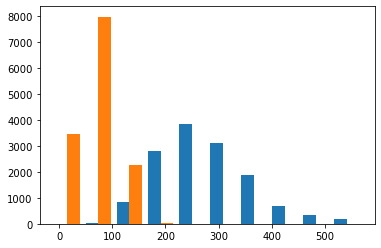

In [9]:
plt.hist(Yvar) # blue is water orange is ET

# Check one example (may skip this)

In [10]:
i=0
nsteps = WU[WU['E_Label_ParcelID'] == prcl].shape[0]
coefs = np.array([[[a11[i],a12[i]],[a21[i],a22[i]]]]) # A
sigma_u = np.array([[sig2_1[i],sig12[i]],[sig12[i],sig2_2[i]]]) # u
coefs_exog = np.array([c1[i],c2[i]]) # v
vnames = ["TotalWaterUse","ET_turf_month_mean"]

# truth
VARP = statsmodels.tsa.vector_ar.var_model.VARProcess(coefs=coefs,coefs_exog=coefs_exog,sigma_u =sigma_u ,names=vnames )
Y = VARP.simulate_var(steps=500, seed=1)[-nsteps:,:]

In [11]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [12]:
print(coefs)
print(sigma_u)
print(correlation_from_covariance(sigma_u))

[[[0.91089537 0.07399186]
  [0.02157549 0.74118181]]]
[[195.92063197   0.        ]
 [  0.          57.58085678]]
[[1. 0.]
 [0. 1.]]


In [13]:
# fit
model = statsmodels.tsa.api.VAR(Y_train)
Y_train = Y[:-12,:] # fixed train
Y_test = Y[-12:,:]
ylag = Y_train[-p:]
model = statsmodels.tsa.api.VAR(Y_train)
results = model.fit(1)
results.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Apr, 2022
Time:                     13:20:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.30012
Nobs:                     124.000    HQIC:                   9.21909
Log likelihood:          -914.043    FPE:                    9544.05
AIC:                      9.16365    Det(Omega_mle):         9098.47
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        37.665327        12.355791            3.048           0.002
L1.y1         0.842385         0.045697           18.434           0.000
L1.y2         0.050735         0.126008            0.403           0.687

Results for equation 

In [14]:
print(results.forecast_cov(1) )
prd,l,u= results.forecast_interval(ylag,1)
print(u[0,0]-prd[0,0])
print(np.sqrt(results.forecast_cov(1)[0,0,0])*norm.ppf(0.975) )

[[[183.69033853   3.55542206]
  [  3.55542206  49.60040599]]]
26.56386401184551
26.5638640118455


In [15]:
# truth
VARP = statsmodels.tsa.vector_ar.var_model.VARProcess(coefs=coefs,coefs_exog=coefs_exog,sigma_u =sigma_u ,names=vnames )
Ysim = VARP.simulate_var(steps=1000000, seed=1)[200:,:]
model = statsmodels.tsa.api.VAR(Ysim)
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Apr, 2022
Time:                     13:20:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.32885
Nobs:                     999799.    HQIC:                   9.32880
Log likelihood:      -7.50075e+06    FPE:                    11257.4
AIC:                      9.32878    Det(Omega_mle):         11257.3
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        15.674687         0.121173          129.358           0.000
L1.y1         0.911346         0.000410         2224.080           0.000
L1.y2         0.073463         0.001236           59.442           0.000

Results for equation 

In [16]:
u = results.forecast_cov()[0]
v = results.coefs_exog
A = results.coefs[0]
ylag2 = Y_train[-p:].reshape((-1,1))

varsim = []

for i in range(10000):
    y = v + np.matmul(A, ylag2) + np.random.multivariate_normal([0,0],u).reshape((-1,1))
    varsim.append(y)
    ylag2 = y

In [17]:
varsimy = np.array([np.array(y.reshape(-1)) for y in varsim])

In [18]:
varsimP =  statsmodels.tsa.vector_ar.var_model.VARProcess(coefs=A.reshape((1,2,2)),coefs_exog=v.reshape(-1),sigma_u =u  ,names=vnames )
varsimy = varsimP.simulate_var(steps=10000, seed=1)


In [19]:
model = statsmodels.tsa.api.VAR(varsimy[:-5000,:])
results = model.fit(1)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Apr, 2022
Time:                     13:20:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.33289
Nobs:                     4999.00    HQIC:                   9.32781
Log likelihood:          -37488.6    FPE:                    11215.7
AIC:                      9.32507    Det(Omega_mle):         11202.3
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        16.729044         1.657587           10.092           0.000
L1.y1         0.909017         0.005794          156.892           0.000
L1.y2         0.064382         0.017428            3.694           0.000

Results for equation 

In [20]:
prd12,l12,u12 = results.forecast_interval(varsimy[-5001:-5000,:] , 5000, alpha=alpha)
t11 = np.stack([prd12[:,0], l12[:,0], u12[:,0]],axis=1)

In [21]:
get_RMSE_NLL_NOIS_AWPI_ECPI(varsimy[-5000:,0],t11[:,0],t11[:,1],t11[:,2])
 

(34.94067992178976,
 4.971942510550309,
 158.35614675431924,
 136.42227459743205,
 0.9516)

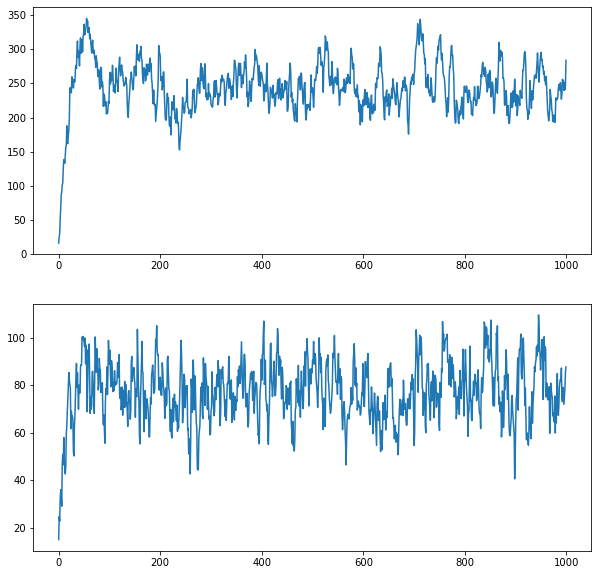

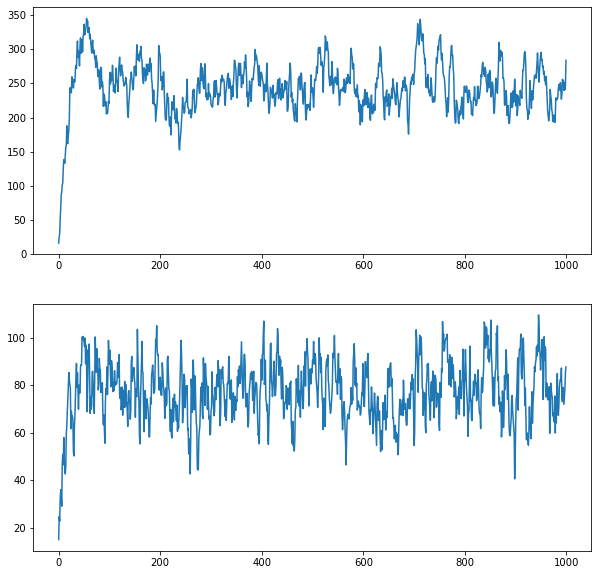

In [22]:
VARP.plotsim()

# construct pd

In [23]:
WUsim = WU[WU['E_Label_ParcelID'].isin(parcels)]
WUsim.loc[:,"TotalWaterUse"] = Yvar[:,0]
WUsim.loc[:,"ET_turf_month_mean"] = Yvar[:,1]

In [25]:
# sim X irrelevant or slightly relavent  
np.random.seed(1)
ar = []
none_sim_list = ['Index','year','ParcelID','Days','year','month',
                 'TotalWaterUse', 'monthIndex',
                 'X_Coord_of_Centroid', 'Y_Coord_ofCentroid',
                 'Set','ET_turf_month_mean','E_Label_ParcelID']
for i,f in enumerate(WUsim.columns):
    if f in none_sim_list:
        continue
    
    n = WUsim.shape[0]
    sig = 2
    rvs = uniform.rvs(-i,i*2,n)
    rvs_perb = uniform.rvs(loc=rvs-sig,scale=2*sig,size=n)
    WUsim.iloc[:,i] = rvs
    # parcel level
    ar.append(rvs_perb) # counts for w uncertainty used to compute y
    print(i,f)

9 AW_percent_month_mean
10 GIR1_month_mean
11 RAW2_month_mean
12 P_month_mean
14 XF_AREA
15 GreenSpace_Est
16 BldVal
17 LndVal
19 Shape_Area


In [26]:
# done
WUsim

Index  TotalWaterUse  year  month  monthIndex  E_Label_ParcelID  \
0           1     181.489686  1998      9         9.0                 1   
1           2     185.111934  1998     10        10.0                 1   
2           3     204.270665  1998     11        11.0                 1   
3           4     254.840034  1998     12        12.0                 1   
4           5     248.507530  1999      1        13.0                 1   
...       ...            ...   ...    ...         ...               ...   
13695  133160     278.537707  2009      9       141.0               972   
13696  133161     283.180113  2009     10       142.0               972   
13697  133162     299.641961  2009     11       143.0               972   
13698  133163     268.138961  2009     12       144.0               972   
13699  133164     273.209667  2010      1       145.0               972   

       X_Coord_of_Centroid  Y_Coord_ofCentroid                ParcelID  \
0              473588.7674         1338172.346  172825090000075000670U   
1              473588.7674         1338172.346  172825090000075000670U   
2              473588.7674         1338172.346  172825090000075000670U   
3              473588.7674         1338172.346  172825090000075000670U   
4              473588.7674         1338172.346  172825090000075000670U   
...                    ...                 ...                     ...   
13695          533602.4000         1312373.000  1929231OV000000000260U   
13696          533602.4000         1312373.000  1929231OV000000000260U   
13697          533602.4000         1312373.000  1929231OV000000000260U   
13698          533602.4000         1312373.000  1929231OV000000000260U   
13699          533602.4000         1312373.000  1929231OV000000000260U   

       AW_percent_month_mean  ...  RAW2_month_mean  P_month_mean  \
0                  -1.493604  ...         0.729787      4.362512   
1                   3.965841  ...         8.357321    -10.062394   
2                  -8.997941  ...         3.215651    -11.648748   
3                  -3.558014  ...         4.531858    -11.560929   
4                  -6.358394  ...         0.939318     -6.500128   
...                      ...  ...              ...           ...   
13695              -6.604142  ...         8.069954      8.156950   
13696              -1.972850  ...         6.788131      5.538798   
13697               7.108843  ...        -1.203478     -4.030085   
13698               2.805821  ...        -9.423126      2.313275   
13699               3.339553  ...        -7.237149      2.796672   

       ET_turf_month_mean    XF_AREA  GreenSpace_Est     BldVal     LndVal  \
0               80.334730  10.488606       11.578448   2.029379  -3.029340   
1               86.391729   8.882793       -6.757903  -4.740033  -3.741361   
2               88.505941  -1.237090       -5.441890   7.674969   5.746329   
3               80.423276   5.692241      -11.233206  10.533542  11.732755   
4               72.377706  11.034732       -9.774822  -0.474788 -15.520936   
...                   ...        ...             ...        ...        ...   
13695          111.069707   0.853397        9.569555  -4.135272 -10.928258   
13696          117.015402  -5.061605       -2.702620   2.090641 -12.139469   
13697          115.826920  -6.964339        7.920916 -15.300818 -12.269391   
13698          115.860801   1.166739        9.942875   5.400394  -7.448283   
13699          113.852313   3.605672        1.908967  -9.990932   6.762491   

       Days  Shape_Area    Set  
0        30  -16.881093  train  
1        31   11.667026  train  
2        30    9.772762  train  
3        31   -5.657357  train  
4        31   -4.471079  train  
...     ...         ...    ...  
13695    30   -9.468680   test  
13696    31   -6.869498   test  
13697    30    8.263780   test  
13698    31  -14.141633   test  
13699    31   12.994052   test  

[13700 rows x 21 columns]

In [29]:
path = 'VAR//WU.feather' # modify
feather.write_dataframe(WUsim, path)

In [30]:
np.save('VAR//test_results_1',test_results_1)
np.save('VAR//test_results_12',test_results_12)